In [1]:
import torch
import configparser
from customDatasetMakers import state_to_dic, ian_dataset
from dataSettings import get_denormalized_dic, get_normalized_dic
from customModels import IanRNN, HiroLRAN
from train_helpers import get_state_mask, get_sample_time_state_mask, masked_loss
import numpy as np
import matplotlib.pyplot as plt
from prediction_helpers import get_ml_truth, get_ml_profile_warmup, get_ml_actuator_trajectory, get_ml_predictions, get_considered_models, get_fast_profile_prediction
import pickle
import os


LOAD MODEL

In [24]:
#model_name = 'HiroLRAN_everything'
model_name = 'HiroLRAN_betan7'
config_filename = f'/projects/EKOLEMEN/profile_predictor/joe_hiro_models/{model_name}config'
config=configparser.ConfigParser()
config.read(config_filename)
output_filename_base=config['model']['output_filename_base']
output_dir=config['model']['output_dir']
profiles=config['inputs']['profiles'].split()
actuators=config['inputs']['actuators'].split()
parameters=config['inputs'].get('parameters','').split()
calculations=config['inputs'].get('calculations','').split()
nwarmup = 3
prediction_length = 300

considered_model = get_considered_models(config_filename, ensemble=False)

Using /projects/EKOLEMEN/profile_predictor/joe_hiro_models/HiroLRAN_betan7.tar


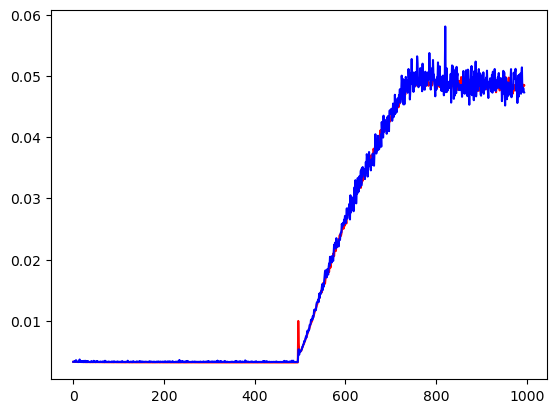

In [25]:
model_file=os.path.join(output_dir, f'{output_filename_base}.tar')
saved_state=torch.load(model_file, map_location=torch.device('cpu'))
plt.plot(saved_state['train_losses'][5:],c='r',label='train')
plt.plot(saved_state['val_losses'][5:],c='b',label='validation')


LOAD DATABASE

In [26]:
data_filename = config['preprocess']['preprocessed_data_filenamebase'] + 'val.pkl'
x_test, y_test, shots, start_times = ian_dataset(data_filename,profiles,parameters,calculations,actuators,sort_by_size=True)

SELECT SHOT

In [33]:
shot_index = 10
print(f'Shot {shots[shot_index]}')
print(f'Start time {start_times[shot_index]}')


Shot 175285
Start time 320


VISUALIZE MODEL PREDICTONS

Bucket 1/1 took 0s
Took 0.19 s


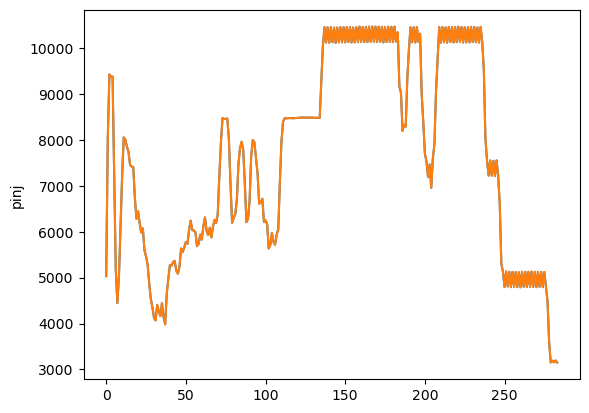

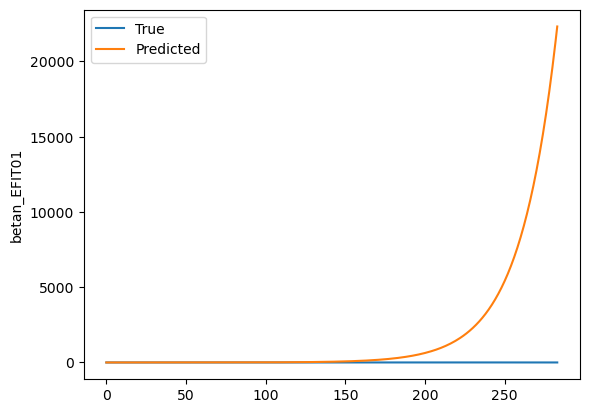

In [36]:
actuator_trajectory = get_ml_actuator_trajectory(x_test[shot_index:shot_index+1], profiles, parameters, calculations, actuators, nwarmup=nwarmup, prediction_length=prediction_length)
'''for i, actuator in enumerate(actuators):
    plt.plot(actuator_trajectory[shot_index, i, :])
    plt.ylabel(actuator)
    plt.show()'''

warmup_profiles, warmup_parameters = get_ml_profile_warmup(x_test[shot_index:shot_index+1], profiles, parameters, calculations, actuators, recorded_profiles=profiles, recorded_parameters=parameters, nwarmup=nwarmup)
true_profiles, true_params = get_ml_truth(y_test[shot_index:shot_index+1], profiles, parameters, calculations, nwarmup=nwarmup, prediction_length=-1)
predicted_profiles, predicted_params = get_ml_predictions(x_test[shot_index:shot_index+1], y_test[shot_index:shot_index+1],
                profiles, parameters, calculations, actuators,
                considered_models=considered_model,
                recorded_profiles=profiles,
                recorded_actuators=actuators,
                recorded_parameters=parameters,
                prediction_length=-1,nwarmup=3,
                use_fancy_normalization=False,
                bucket_size=10000)

combined_true_profiles = np.concatenate((warmup_profiles, true_profiles), axis=2)
combined_predicted_profiles = np.concatenate((warmup_profiles, predicted_profiles), axis=2)
combined_true_params = np.concatenate((warmup_parameters, true_params), axis=2)
combined_predicted_params = np.concatenate((warmup_parameters, predicted_params), axis=2)
for i, actuator in enumerate(actuators):
    plt.plot(actuator_trajectory[0, i, :])
    plt.plot(actuator_trajectory[0, i, :])
    plt.ylabel(actuator)
    plt.show()
for i, parameter in enumerate(parameters):
    plt.plot(combined_true_params[0, i, :], label='True')
    plt.plot(combined_predicted_params[0, i, :], label='Predicted')
    plt.ylabel(parameter)
    plt.legend()
    plt.show()
for i, profile in enumerate(profiles):
    plt.plot(combined_true_profiles[0, i, :, 0])
    plt.plot(combined_predicted_profiles[0, i, :, 0])
    plt.ylabel(profile)
    plt.show()


PLOTS FROM ROLLOUT

In [98]:
with open('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/test_rollout_alldiiid_ensemble.pkl', 'rb') as f:
    data = pickle.load(f)
with open('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/rollout_alldiiid_ensemble.pkl', 'rb') as f:
    data2 = pickle.load(f)

In [45]:
directory = '/projects/EKOLEMEN/profile_predictor/joe_hiro_models/'

with open(f'{directory}rollout_{model_name}.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [48]:
ensemble_model_predictions_list = []
for i in range(4):
    with open(f'{directory}rollout_alldiiid_ensemble{i}_RESUMED.pkl', 'rb') as f:
        all_data = pickle.load(f)
        ensemble_model_predictions_list.append(all_data[list(all_data.keys())[index]])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q', r'$Z_{eff}$']
actuator_labels = ['P_NBI / MW', 'torque / Nm', 'Ip / A','Bt / T','gas', 'P_ECH / MW', 'Triangularity bot', 'Triangularity top', r'$\kappa$', 'a minor / m', r'Volume $m^3$', 'R major / m']
timetrace = data['truth']['actuators'][actuators[0]]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1], axes[:,2]], axis=0)
# Initialize line objects for each subplot
predictions = [ax.plot([], [], lw=2, label='Predictions')[0] for ax in axes]
targets = [ax.plot([], [], lw=2, label='Truth')[0] for ax in axes]
ensemble_1 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
ensemble_2 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
ensemble_3 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
ensemble_4 = [ax.plot([], [], lw=2, color='C0', alpha=0.3)[0] for ax in axes]
# Set subplot limits and labels
for i, ax in enumerate(axes):
    if i < len(actuators):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000, alpha=0.3)
        elif actuator_labels[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000000, alpha=0.3)
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]], alpha=0.3)
    else:
        ax.set_xlim(0, 1)
        if i -len(actuators) < len(profiles):
            ax.set_ylim(0, np.max(data['truth']['profiles'][profiles[i-len(actuators)]][:])*1.2)
            ax.set_ylabel(profile_labels[i-len(actuators)])
        ax.legend()
axes[5].set_xlabel('Time / ms')
axes[11].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')

def animate(time):
    for i in range(len(axes)):
        if i < len(actuators):
            if actuator_labels[i] == 'P_NBI / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time]/1000)
            else:
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time])
            #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0][:])
        else:
            
            predictions[i].set_data(rhos, np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[i-len(actuators)]][0][time] for j in range(4)]), axis=0))
            
            targets[i].set_data(rhos, data['truth']['profiles'][profiles[i-len(actuators)]][time])
            ensemble_1[i].set_data(rhos, ensemble_model_predictions_list[0]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            ensemble_2[i].set_data(rhos, ensemble_model_predictions_list[1]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            ensemble_3[i].set_data(rhos, ensemble_model_predictions_list[2]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            ensemble_4[i].set_data(rhos, ensemble_model_predictions_list[3]['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
    return predictions + targets
fig.suptitle('Simulation of shot 185885', fontsize=16)
ani = animation.FuncAnimation(fig, animate, frames=len(timetrace), interval=50, blit=True)
ani.save(f'{model_name}{index}.mp4', writer='ffmpeg')
HTML(ani.to_html5_video())

In [49]:

full_arrs = np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[15-len(actuators)]][0] for j in range(4)])
print(np.mean(full_arrs, axis=-1).shape)
#print(np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[15-len(actuators)]][0][:, :] for j in range(4)]), axis=0))

(4, 271)


In [ ]:
fig, axes = plt.subplots(nrows=len(data['truth']['actuators'].keys())+len(data['truth']['parameters'].keys())+len(data['truth']['profiles'].keys()), ncols=1, figsize=(8, 20), sharex=True)
actuator_labels = ['P_NBI / W', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / W']
#profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
#parameter_labels = ['betaN']
actuator_labels = list(data['truth']['actuators'].keys())
profile_labels = list(data['truth']['profiles'].keys())
parameter_labels = list(data['truth']['parameters'].keys())
time = np.arange(len(data['truth']['actuators'][actuators[0]]))*20

for i, ax in enumerate(axes):
    if i < len(actuators):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.plot(time, data['truth']['actuators'][actuators[i]]/1000)
            ax.set_ylabel(f'{actuator_labels[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
        else:
            ax.plot(time, data['truth']['actuators'][actuators[i]])
            ax.set_ylabel(f'{actuator_labels[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
    elif i < len(actuators) + len(parameters):
        ax.plot(time[:], data['predictions']['parameters'][parameters[i-len(actuators)]][0], label='predicted')
        ax.plot(time, data['truth']['parameters'][parameters[i-len(actuators)]], label='truth')
        ax.set_ylabel(f'{parameter_labels[i-len(actuators)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
    else:

        #predicted_mean = np.mean(data['predictions']['profiles'][profiles[i - len(actuators) - len(parameters)]][0], axis=1)
        predicted_mean = np.mean(np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[i-len(actuators)]][0] for j in range(4)]), axis=-1), axis=0)
        predicted_std = np.std(np.mean(np.array([ensemble_model_predictions_list[j]['predictions']['profiles'][profiles[i-len(actuators)]][0] for j in range(4)]), axis=-1), axis=0)
        truth_mean = np.mean(data['truth']['profiles'][profiles[i - len(actuators) - len(parameters)]], axis=1)
        ax.plot(time, predicted_mean, label='predicted')
        ax.plot(time, truth_mean, label='truth')
        ax.set_ylabel(f'{profile_labels[i-len(actuators)-len(parameters)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
        #ax.set_ylim(bottom=0)

# Set the x-axis label for the bottom subplot
axes[-1].set_xlabel('Time / ms')
axes[len(actuators)].legend()
axes[0].set_title('Actuators')
axes[len(actuators)].set_title('Predicted Profiles')
plt.subplots_adjust(hspace=0.1)
plt.savefig(f'{model_name}{index}.png')
# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
actuator_labels = ['P_NBI / MW', 'torque / Nm', 'Ip / A','Bt / T','gas', 'P_ECH / MW', 'Triangularity bot', 'Triangularity top', r'$\kappa$', 'a minor / m', r'Volume $m^3$', 'R major / m']
timetrace = data['truth']['actuators'][actuators[0]]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1], axes[:,2]], axis=0)[:-1]
# Initialize line objects for each subplot
predictions = [ax.plot([], [], lw=2, label='Predictions')[0] for ax in axes]
targets = [ax.plot([], [], lw=2, label='Truth')[0] for ax in axes]

# Set subplot limits and labels
for i, ax in enumerate(axes):
    if i < len(actuators):
        if actuator_labels[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000, alpha=0.2)
        elif actuator_labels[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2/1000000)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]]/1000000, alpha=0.2)
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(data['truth']['actuators'][actuators[i]])*1.2)
            ax.set_ylabel(actuator_labels[i])
            ax.plot(np.arange(len(timetrace[:]))*20, data['truth']['actuators'][actuators[i]], alpha=0.2)
    else:
        ax.set_xlim(0, 1)
        if i -len(actuators) < len(profiles):
            ax.set_ylim(0, np.max(data['truth']['profiles'][profiles[i-len(actuators)]][:])*1.2)
            ax.set_ylabel(profile_labels[i-len(actuators)])
        ax.legend()
axes[len(actuators)].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')

def animate(time):
    for i in range(len(axes)):
        if i < len(actuators):
            if actuator_labels[i] == 'P_NBI / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time]/1000)
            else:
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, data['truth']['actuators'][actuators[i]][:time])
            #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0][:])
        else:
            predictions[i].set_data(rhos, data['predictions']['profiles'][profiles[i-len(actuators)]][0][time])
            targets[i].set_data(rhos, data['truth']['profiles'][profiles[i-len(actuators)]][time])
    return predictions + targets

ani = animation.FuncAnimation(fig, animate, frames=6, interval=150, blit=True)
ani.save(f'{model_name}{index}.mp4', writer='ffmpeg')
HTML(ani.to_html5_video())